# Import data, identify contours and convert to points

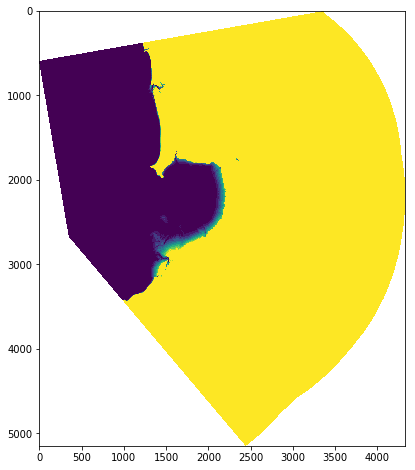

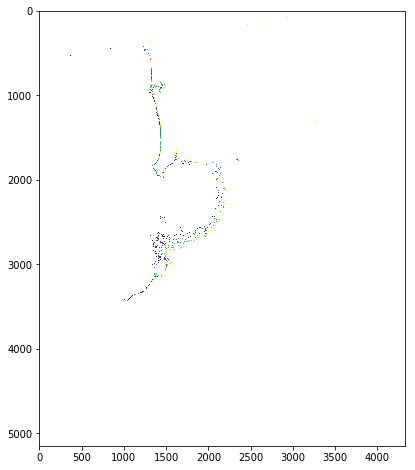

In [12]:
import numpy as np
import datacube
import rasterio
import rasterio.features
import glob
from osgeo import gdal
from shapely.geometry import Point
from shapely.geometry import shape
import scipy.ndimage
from scipy.interpolate import griddata, LinearNDInterpolator
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
from matplotlib import pyplot as plt


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None  


# Import raster
filename = glob.glob("/g/data2/v10/ITEM/offset_products/ITEM_OFFSET_209*.tif")[0]
src_ds = gdal.Open(filename)
srcband = src_ds.GetRasterBand(1)
srcarray = srcband.ReadAsArray() 
yrows, xcols = srcarray.shape
prj = src_ds.GetProjection()
geotrans = src_ds.GetGeoTransform()
(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size) = geotrans

# Copy original layer so array can be modified 
item_array = np.copy(srcarray)

# Set nodata to NaN, and force 0 values to a low negative to allow contour extraction
item_array[item_array == -6666] = np.nan
item_array[item_array == 0] = -3000
plt.figure(figsize = (8, 8))
plt.imshow(item_array)  
plt.show()

# Erode background to fix differences at plot edge
background = np.isfinite(item_array)
background_eroded = scipy.ndimage.binary_erosion(background)

# Compute local minima and subtract from source array to identify contours
neighborhood = morphology.generate_binary_structure(len(item_array.shape), 2)
local_minima = filters.minimum_filter(item_array, footprint = neighborhood)
local_minima = (item_array - local_minima) != 0
local_minima[~background_eroded] = 0

# Return only input ITEM offset data for non-background and local minima areas
item_array[~local_minima] = np.nan
plt.figure(figsize = (8, 8))
plt.imshow(item_array)
plt.show()

# Export to file
write_geotiff(fname = "test_contours4.tif", 
              data = item_array, 
              geo_transform = geotrans, 
              projection = prj, 
              nodata_val = 0)

# Convert cells to points
y_inds, x_inds = np.nonzero(local_minima)
centroids = [(y_ind * y_size + upleft_y + (y_size / 2),
              x_ind * x_size + upleft_x + (x_size / 2)) for (y_ind, x_ind) in zip(y_inds, x_inds)]
points = np.array(centroids)
values = item_array[local_minima]

# Interpolate points

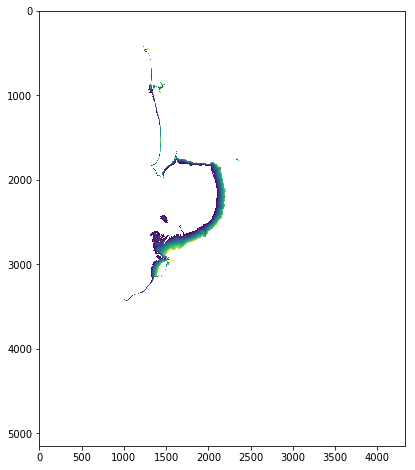

In [15]:
# Extract bounds
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid
interpolated_array = griddata(points, values, (grid_y, grid_x), method = 'linear')

# Mask out zero values and max tidal stage from original ITEM offset layer
mask = ((srcarray == -6666) | (srcarray == 0) | (srcarray == np.max(srcarray)))
interpolated_array[mask] = np.nan

# Plot
plt.figure(figsize = (8, 8))
plt.imshow(interpolated_array)
plt.show()

# Export to tif
write_geotiff(fname = "test_dem4.tif", 
              data = interpolated_array, 
              geo_transform = geotrans, 
              projection = prj, 
              nodata_val = np.nan)
